In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
from copy import deepcopy

In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv('AMZN.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


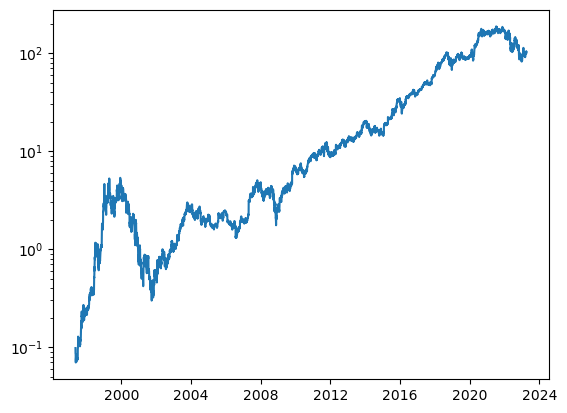

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Close'])
plt.yscale('log')

In [19]:
def prep_df_for_lstm(df, n_steps):
    df = df.copy()
    df = df[['Date', 'Close']]
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close-{i}'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

prep_df_for_lstm(df, 8)

,Close,Close-1,Close-2,Close-3,Close-4,Close-5,Close-6,Close-7,Close-8
Date,,,,,,,,,
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-03,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001,97.709999
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define grid dimensions
n_rows = 30
n_cols = 80

# Create grid indices
row_indices = np.arange(n_rows)
col_indices = np.arange(n_cols)
col_indices, row_indices = np.meshgrid(col_indices, row_indices)

# Calculate distance from center for each grid point
center_row = n_rows // 2
center_col = n_cols // 2
distances = np.sqrt((row_indices - center_row)**2 + (col_indices - center_col)**2)

# Define parameters for Gaussian distribution
sigma = min(n_rows, n_cols) / 6  # Adjust the standard deviation as needed for the spread
mean_row = center_row
mean_col = center_col

# Calculate Gaussian weights
gaussian_weights = np.exp(-(distances**2) / (2 * sigma**2))

# Normalize weights to sum up to 1
gaussian_weights /= np.sum(gaussian_weights)

# Create original grid (for visualization purposes)
original_grid = np.zeros((n_rows, n_cols))
original_grid[center_row, center_col] = 1  # Set the center to 1 for visualization


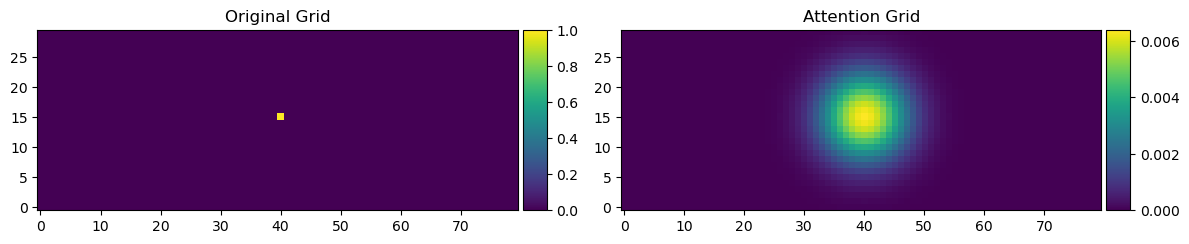

In [6]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot original grid
im1 = axs[0].imshow(original_grid, cmap='viridis', origin='lower')
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
axs[0].set_title('Original Grid')

# Plot attention grid
im2 = axs[1].imshow(gaussian_weights, cmap='viridis', origin='lower')
divider = make_axes_locatable(axs[1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
axs[1].set_title('Attention Grid')

plt.tight_layout()
plt.show()

In [7]:
import numpy as np

# Define the dimensions of the spherical grid
num_latitude_points = 30
num_longitude_points = 80

# Generate latitude and longitude coordinates
latitude = np.linspace(-np.pi/2, np.pi/2, num_latitude_points)  # Range from -90 degrees to 90 degrees
longitude = np.linspace(-np.pi, np.pi, num_longitude_points)  # Range from -180 degrees to 180 degrees

# Create a meshgrid of latitude and longitude
latitude_mesh, longitude_mesh = np.meshgrid(latitude, longitude)

# Now you have latitude_mesh and longitude_mesh arrays representing the spherical grid
# You can use these arrays to calculate values or apply operations on the spherical grid




In [27]:
import datetime as datetime
date = np.array([datetime.datetime(2024, 1, i) for i in range(1, 31)])
values = np.arange(30)

arr = np.vstack((date, values)).T
arr

array([[datetime.datetime(2024, 1, 1, 0, 0), 0],
       [datetime.datetime(2024, 1, 2, 0, 0), 1],
       [datetime.datetime(2024, 1, 3, 0, 0), 2],
       [datetime.datetime(2024, 1, 4, 0, 0), 3],
       [datetime.datetime(2024, 1, 5, 0, 0), 4],
       [datetime.datetime(2024, 1, 6, 0, 0), 5],
       [datetime.datetime(2024, 1, 7, 0, 0), 6],
       [datetime.datetime(2024, 1, 8, 0, 0), 7],
       [datetime.datetime(2024, 1, 9, 0, 0), 8],
       [datetime.datetime(2024, 1, 10, 0, 0), 9],
       [datetime.datetime(2024, 1, 11, 0, 0), 10],
       [datetime.datetime(2024, 1, 12, 0, 0), 11],
       [datetime.datetime(2024, 1, 13, 0, 0), 12],
       [datetime.datetime(2024, 1, 14, 0, 0), 13],
       [datetime.datetime(2024, 1, 15, 0, 0), 14],
       [datetime.datetime(2024, 1, 16, 0, 0), 15],
       [datetime.datetime(2024, 1, 17, 0, 0), 16],
       [datetime.datetime(2024, 1, 18, 0, 0), 17],
       [datetime.datetime(2024, 1, 19, 0, 0), 18],
       [datetime.datetime(2024, 1, 20, 0, 0), 19],

In [31]:
import datetime as datetime
import numpy as np

date = np.array([datetime.datetime(2024, 1, i) for i in range(1, 31)])
values = np.arange(30)
arr = np.vstack((date, values)).T

date_to_remove = datetime.datetime(2024, 1, 15)
filter_arr = arr[arr[:, 0] != date_to_remove]
filter_arr = filter_arr[filter_arr[:, 0] != date_to_remove + datetime.timedelta(days=1)]
filter_arr = filter_arr[filter_arr[:, 0] != date_to_remove + datetime.timedelta(days=2)]
filter_arr = filter_arr[filter_arr[:, 0] != date_to_remove + datetime.timedelta(days=3)]

filter_arr

array([[datetime.datetime(2024, 1, 1, 0, 0), 0],
       [datetime.datetime(2024, 1, 2, 0, 0), 1],
       [datetime.datetime(2024, 1, 3, 0, 0), 2],
       [datetime.datetime(2024, 1, 4, 0, 0), 3],
       [datetime.datetime(2024, 1, 5, 0, 0), 4],
       [datetime.datetime(2024, 1, 6, 0, 0), 5],
       [datetime.datetime(2024, 1, 7, 0, 0), 6],
       [datetime.datetime(2024, 1, 8, 0, 0), 7],
       [datetime.datetime(2024, 1, 9, 0, 0), 8],
       [datetime.datetime(2024, 1, 10, 0, 0), 9],
       [datetime.datetime(2024, 1, 11, 0, 0), 10],
       [datetime.datetime(2024, 1, 12, 0, 0), 11],
       [datetime.datetime(2024, 1, 13, 0, 0), 12],
       [datetime.datetime(2024, 1, 14, 0, 0), 13],
       [datetime.datetime(2024, 1, 19, 0, 0), 18],
       [datetime.datetime(2024, 1, 20, 0, 0), 19],
       [datetime.datetime(2024, 1, 21, 0, 0), 20],
       [datetime.datetime(2024, 1, 22, 0, 0), 21],
       [datetime.datetime(2024, 1, 23, 0, 0), 22],
       [datetime.datetime(2024, 1, 24, 0, 0), 23],

In [37]:
import datetime as datetime
import numpy as np

date = np.array([datetime.datetime(2024, 1, i) for i in range(1, 31)])
values = np.arange(30)
arr = np.vstack((date, values)).T

dates_to_remove = [datetime.datetime(2024, 1, 15), datetime.datetime(2024, 1, 21)]
n = 3  # Number of consecutive dates to remove

# Create a mask to filter out the dates to remove and the following n-1 dates for each date
mask = np.ones(len(arr), dtype=bool)
for remove_date in dates_to_remove:
    for i in range(n):
        mask &= arr[:, 0] != remove_date + datetime.timedelta(days=i)

filter_arr = arr[mask]
filter_arr

array([[datetime.datetime(2024, 1, 1, 0, 0), 0],
       [datetime.datetime(2024, 1, 2, 0, 0), 1],
       [datetime.datetime(2024, 1, 3, 0, 0), 2],
       [datetime.datetime(2024, 1, 4, 0, 0), 3],
       [datetime.datetime(2024, 1, 5, 0, 0), 4],
       [datetime.datetime(2024, 1, 6, 0, 0), 5],
       [datetime.datetime(2024, 1, 7, 0, 0), 6],
       [datetime.datetime(2024, 1, 8, 0, 0), 7],
       [datetime.datetime(2024, 1, 9, 0, 0), 8],
       [datetime.datetime(2024, 1, 10, 0, 0), 9],
       [datetime.datetime(2024, 1, 11, 0, 0), 10],
       [datetime.datetime(2024, 1, 12, 0, 0), 11],
       [datetime.datetime(2024, 1, 13, 0, 0), 12],
       [datetime.datetime(2024, 1, 14, 0, 0), 13],
       [datetime.datetime(2024, 1, 18, 0, 0), 17],
       [datetime.datetime(2024, 1, 19, 0, 0), 18],
       [datetime.datetime(2024, 1, 20, 0, 0), 19],
       [datetime.datetime(2024, 1, 24, 0, 0), 23],
       [datetime.datetime(2024, 1, 25, 0, 0), 24],
       [datetime.datetime(2024, 1, 26, 0, 0), 25],

In [38]:
reset_dates = [
    {"start": "2024/01/15 00:00:00"},
    {"start": "2024/01/21 00:00:00"},
    {"start": "2024/01/27 00:00:00"}
]

In [40]:
import datetime as datetime
import numpy as np

date = np.array([datetime.datetime(2024, 1, i) for i in range(1, 31)])
values = np.arange(30)
arr = np.vstack((date, values)).T

reset_dates = [
    {"start": "2024/01/15 00:00:00"},
    {"start": "2024/01/21 00:00:00"},
    {"start": "2024/01/27 00:00:00"}
]

# Convert reset dates to datetime objects
reset_dates_dt = [datetime.datetime.strptime(date["start"], "%Y/%m/%d %H:%M:%S") for date in reset_dates]

n = 3  # Number of consecutive dates to remove

# Create a mask to filter out the reset dates and the following n-1 dates for each reset date
mask = np.ones(len(arr), dtype=bool)
for reset_date in reset_dates_dt:
    for i in range(n):
        mask &= arr[:, 0] != reset_date + datetime.timedelta(days=i)

filter_arr = arr[mask]
filter_arr


array([[datetime.datetime(2024, 1, 1, 0, 0), 0],
       [datetime.datetime(2024, 1, 2, 0, 0), 1],
       [datetime.datetime(2024, 1, 3, 0, 0), 2],
       [datetime.datetime(2024, 1, 4, 0, 0), 3],
       [datetime.datetime(2024, 1, 5, 0, 0), 4],
       [datetime.datetime(2024, 1, 6, 0, 0), 5],
       [datetime.datetime(2024, 1, 7, 0, 0), 6],
       [datetime.datetime(2024, 1, 8, 0, 0), 7],
       [datetime.datetime(2024, 1, 9, 0, 0), 8],
       [datetime.datetime(2024, 1, 10, 0, 0), 9],
       [datetime.datetime(2024, 1, 11, 0, 0), 10],
       [datetime.datetime(2024, 1, 12, 0, 0), 11],
       [datetime.datetime(2024, 1, 13, 0, 0), 12],
       [datetime.datetime(2024, 1, 14, 0, 0), 13],
       [datetime.datetime(2024, 1, 18, 0, 0), 17],
       [datetime.datetime(2024, 1, 19, 0, 0), 18],
       [datetime.datetime(2024, 1, 20, 0, 0), 19],
       [datetime.datetime(2024, 1, 24, 0, 0), 23],
       [datetime.datetime(2024, 1, 25, 0, 0), 24],
       [datetime.datetime(2024, 1, 26, 0, 0), 25],

In [59]:
import datetime as datetime
import numpy as np

date = np.array([datetime.datetime(2024, 1, i) for i in range(1, 31)])
lat = np.linspace(-90, 90, 30)
mlt =np.arange(24)

values = np.arange(30)
np.random.seed(0)
rand_vals = np.random.rand(30)

dims = ["date", "lat", "mlt"]

arr = np.vstack((date, values, mlt, lat, rand_vals)).T


#arr = np.vstack((date, values, rand_vals)).T

reset_dates = [
    {"start": "2024/01/01 00:00:00"},
    {"start": "2024/01/11 00:00:00"},
    {"start": "2024/01/21 00:00:00"}
]

# Convert reset dates to datetime objects
reset_dates_dt = [datetime.datetime.strptime(date["start"], "%Y/%m/%d %H:%M:%S") for date in reset_dates]

n = 5  # Number of entries to remove after each reset date

# Create a mask to filter out the reset dates and the next n entries after each reset date
mask = np.ones(len(arr), dtype=bool)
for reset_date in reset_dates_dt:
    reset_index = np.where(arr[:, 0] == reset_date)[0][0]
    end_index = min(reset_index + n, len(arr))
    mask[reset_index:end_index] = False

filter_arr = arr[mask]

filter_arr.shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 30 and the array at index 2 has size 24

In [27]:
import numpy as np
import datetime as datetime
date = np.array([datetime.datetime(2024, 1, i) for i in range(1, 31)])
lat = np.arange(-90, 90, 1)
mlt =np.arange(24)

date_mesh, lat_mesh, mlt_mesh = np.meshgrid(date, lat, mlt)
np.random.seed(0)
rand_vals = np.random.rand(*date_mesh.shape)


reset_dates = [
    {"start": "2024/01/01 00:00:00"},
    {"start": "2024/01/11 00:00:00"},
    {"start": "2024/01/21 00:00:00"}
]

# Convert reset dates to datetime objects
reset_dates_dt = [datetime.datetime.strptime(date["start"], "%Y/%m/%d %H:%M:%S") for date in reset_dates]

n = 5  # Number of entries to remove after each reset date

mask = np.ones(date_mesh.shape, dtype=bool)
for reset_date in reset_dates_dt:
    reset_index = np.where(date_mesh == reset_date)[0][0]
    end_index = min(reset_index + n, date_mesh.shape[0])
    mask[reset_index:end_index] = False

rand_vals_filtered = rand_vals[mask]
rand_vals_filtered.shape


(126000,)

In [29]:
import numpy as np
import datetime

# Your existing code
date = np.array([datetime.datetime(2024, 1, i) for i in range(1, 31)])
lat = np.arange(-90, 90, 1)
mlt = np.arange(24)

date_mesh, lat_mesh, mlt_mesh = np.meshgrid(date, lat, mlt)
np.random.seed(0)
rand_vals = np.random.rand(*date_mesh.shape)

reset_dates = [
    {"start": "2024/01/01 00:00:00"},
    {"start": "2024/01/11 00:00:00"},
    {"start": "2024/01/21 00:00:00"}
]

# Convert reset_dates to datetime objects and find their indices in date
reset_indices = [np.where(date == datetime.datetime.strptime(d["start"], "%Y/%m/%d %H:%M:%S"))[0][0] for d in reset_dates]

# Delete the corresponding indices from rand_vals
rand_vals = np.delete(rand_vals, reset_indices, axis=1)

print(rand_vals.shape)  # Outputs: (180, 27, 24)

(180, 27, 24)


In [28]:
rand_vals.shape

(180, 30, 24)

In [35]:
import numpy as np
import datetime

# Your existing code
date = np.array([datetime.datetime(2024, 1, i) for i in range(1, 31)])
lat = np.arange(-90, 90, 1)
mlt = np.arange(24)

date_mesh, lat_mesh, mlt_mesh = np.meshgrid(date, lat, mlt)
np.random.seed(0)
rand_vals = np.random.rand(*date_mesh.shape)

reset_dates = [
    {"start": "2024/01/01 00:00:00"},
    {"start": "2024/01/11 00:00:00"},
    {"start": "2024/01/21 00:00:00"}
]

n = 5  # Number of entries to remove after each reset date

# Convert reset_dates to datetime objects and find their indices in date
reset_indices = [np.where(date == datetime.datetime.strptime(d["start"], "%Y/%m/%d %H:%M:%S"))[0][0] for d in reset_dates]

# Add n dates after each reset date to the indices to be removed
reset_indices = np.array([list(range(i, min(i+n, len(date)))) for i in reset_indices]).flatten()

# Delete the corresponding indices from rand_vals
rand_vals = np.delete(rand_vals, reset_indices, axis=1)

rand_vals.shape

(180, 15, 24)

In [36]:
date[0]

datetime.datetime(2024, 1, 1, 0, 0)